In [1]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
import pybedtools
import time
from tqdm import tqdm
import random

# Custom libraries
import prelim_analysis_utils as pa

In [2]:
# Reload modules in case of modifications
reload(pa)

<module 'prelim_analysis_utils' from '/home/louiscam/projects/gpcr/code/preliminary_analysis/prelim_analysis_gene_level_interX/prelim_analysis_utils.py'>

# Data directories

In [3]:
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
# Directory for storing preliminary results
prelim_results_dir = '/home/louiscam/projects/gpcr/save/prelim_results_dir/'

In [4]:
# Specify directories and relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

# Adhesome genes location

In [5]:
# Load adhesome components data
adhesome_components_filename = dir_adhesome+'components.csv'
df_components = pa.load_adhesome_data(adhesome_components_filename)

In [6]:
# Load gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = pa.get_gene_locations(gene_locations_filename, gene_id_filename)

In [7]:
# Find location of adhesome genes
adhesome_loc_df, missing_adhesome_genes = pa.get_adhesome_genes_location(df_components, df_loc)
adhesome_loc_df = pa.get_adhesome_genes_loci(adhesome_loc_df, resol)

Adhesome genes absent from UCSC genes: ['DDEF1', 'GRLF1', 'JUB', 'SH3KBP1', 'MSN', 'FLNA', 'PPP2CA', 'SMPX', 'ITGAW', 'ARHGEF6']


In [8]:
# Add column specifying chromosome number as an int
adhesome_chr_loci = adhesome_loc_df[['gene','chrom','loci']]
adhesome_chr_loci['chrom_int'] = adhesome_chr_loci['chrom'].str.split('chr').str[1].astype(int)
adhesome_chr_loci = adhesome_chr_loci.sort_values(['chrom_int','loci'])

In [9]:
# Also create dataframe with chromosome information for each adhesome gene
adhesome_chr = adhesome_chr_loci.drop_duplicates(subset='gene', keep='first')

# Matrix of adhesome gene Hi-C contacts

In [11]:
# Create matrix of adhesome genes Hi-C contacts
gene_list = np.array(adhesome_chr_loci.gene.drop_duplicates(keep='first'))
gene_contacts_df = pa.build_adhesome_gene_contact_mat(gene_list, adhesome_chr_loci, 
                                                      dir_processed_hic, resol)
# pickle.dump(gene_contacts_df, open(prelim_results_dir+'adhesome_gene_hic_mat_inter.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

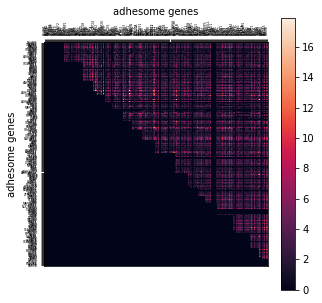

In [12]:
# Plot matrix as heatmap
gene_contacts_df = pickle.load(open(prelim_results_dir+'adhesome_gene_hic_mat_inter.pkl', 'rb'))
pa.plot_heatmap(gene_contacts_df, gene_list, gene_list,'adhesome genes', 'adhesome genes', 5, gene_contacts_df.max().max())

In [13]:
# Transform the gene Hi-C contact dataframe to (index, column, value format)
gene_contacts_full_df = gene_contacts_df+gene_contacts_df.transpose()
new_index = pd.MultiIndex.from_tuples(itertools.combinations(gene_contacts_full_df.index.tolist(), 2),
                                      names=["column","index"])
gene_contacts_full_df1 = gene_contacts_full_df.stack().reindex(new_index).reset_index(name='hic_contact')

In [82]:
# Compare to random genes
random.seed(13)
# Select 222 random genes
df_components_rand = df_loc.iloc[random.sample(range(len(df_loc)), len(gene_list)),[1,2,3,4]].reset_index(drop=True)
df_components_rand.columns = ['gene','chrom','genoStart','genoEnd']
df_components_rand['geneLength'] = df_components_rand['genoEnd']-df_components_rand['genoStart']
# Find the corresponding loci
rand_loc_df = pa.get_adhesome_genes_loci(df_components_rand, resol)
rand_chr_loci = rand_loc_df.iloc[:,[0,1,2]]
rand_chr_loci['chrom_int'] = rand_loc_df['chrom'].str.split('chr').str[1].astype(int)
rand_chr_loci = rand_chr_loci.sort_values(['chrom_int','loci'])
# Create matrix of random genes Hi-C contacts
gene_list_rand = np.array(rand_chr_loci.gene.drop_duplicates(keep='first'))
gene_contacts_df_rand = pa.build_adhesome_gene_contact_mat(gene_list_rand, rand_chr_loci, 
                                                      dir_processed_hic, resol)
# pickle.dump(gene_contacts_df_rand, open(prelim_results_dir+'rand_gene_hic_mat_inter.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 231/231 [00:58<00:00,  3.92it/s]


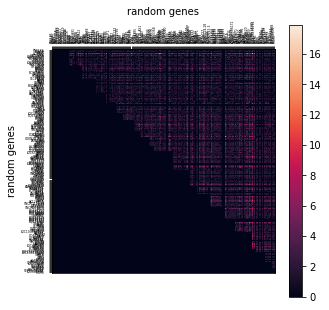

In [101]:
# Plot matrix as heatmap
gene_contacts_df_rand = pickle.load(open(prelim_results_dir+'rand_gene_hic_mat_inter.pkl', 'rb'))
pa.plot_heatmap(gene_contacts_df_rand, gene_list_rand, gene_list_rand,'random genes', 'random genes', 5, gene_contacts_df.max().max())

Mean Hi-C between adhesome genes = 1.9652143456131987
Mean Hi-C between random genes = 1.2294306239650923


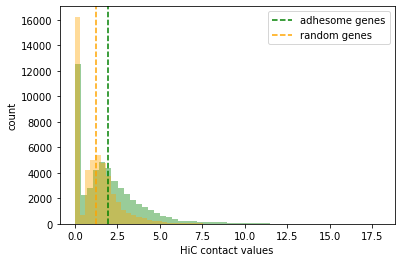

In [103]:
# Compare distributions
plt.figure()
gene_contacts_df_full = gene_contacts_df+gene_contacts_df.transpose()
sns.distplot(gene_contacts_df_full.values.flatten(), 
             kde=False, hist=True, 
             color='green',
             axlabel='HiC contact values', label='HiC interX contacts between adhesome genes')
plt.axvline(np.mean(gene_contacts_df_full.values.flatten()), color='green', linestyle='dashed')
print('Mean Hi-C between adhesome genes = '+str(np.mean(gene_contacts_df_full.values.flatten())))
gene_contacts_df_rand_full = gene_contacts_df_rand+gene_contacts_df_rand.transpose()
sns.distplot(gene_contacts_df_rand_full.values.flatten(), 
             kde=False, hist=True, 
             color='orange',
             axlabel='HiC contact values', label='HiC interX contacts between random genes')
plt.axvline(np.mean(gene_contacts_df_rand_full.values.flatten()), color='orange', linestyle='dashed')
print('Mean Hi-C between random genes = '+str(np.mean(gene_contacts_df_rand_full.values.flatten())))
plt.ylabel('count')
plt.legend(['adhesome genes','random genes'], loc='upper right')
plotname = 'adhesome_random_hic_contacts_interX_genes'+'.pdf'
#plt.savefig(prelim_results_dir+plotname, format='pdf')
plt.show()

In [116]:
# Store adhesome gene pairs with highest Hi-C contact values as pickle
threshold = np.quantile(gene_contacts_full_df1['hic_contact'], 0.9)
top_adhesome_gene_pairs = gene_contacts_full_df1[gene_contacts_full_df1['hic_contact']>threshold].sort_values(by='hic_contact', ascending=False)
print(len(top_adhesome_gene_pairs))
pickle.dump(top_adhesome_gene_pairs, open(prelim_results_dir+'top_adhesome_gene_pairs.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

2453


# Adhesome network interactions

In [118]:
# Load interactions
interactions_filename = 'interactions.csv'
df_interactions = pd.read_csv(dir_adhesome+interactions_filename, sep = ',', header = 0)
df_interactions['Type'] = df_interactions['Type'].str.lower().str.replace('_reaction','')

In [119]:
# Remove missing genes from edge list
df_interactions = df_interactions[~df_interactions['Source'].isin(missing_adhesome_genes)]
df_interactions = df_interactions[~df_interactions['Target'].isin(missing_adhesome_genes)]

In [120]:
# Remove non-genes from edge list (e.g. calcium)
df_interactions = df_interactions[df_interactions['Source'].isin(gene_list)]
df_interactions = df_interactions[df_interactions['Target'].isin(gene_list)]

In [121]:
# Add chromosome information for source and target genes
df_interactions = pd.merge(df_interactions, adhesome_chr[['gene','chrom']].add_suffix('_source'), 
                       how='inner', left_on='Source', right_on='gene_source')
df_interactions = pd.merge(df_interactions, adhesome_chr[['gene','chrom']].add_suffix('_target'), 
                       how='inner', left_on='Target', right_on='gene_target')
df_interactions = df_interactions.drop(['gene_source','gene_target'], axis=1)
df_interactions['same_chrom'] = df_interactions['chrom_source']==df_interactions['chrom_target']

In [122]:
# Remove edges between genes located on the same chromosomes
df_interactions = df_interactions[df_interactions['same_chrom']==False]

# ROC based on interaction effect

In [123]:
# Distribution of effects
df_interactions.Effect.value_counts()

0    4900
+     643
_     213
Name: Effect, dtype: int64

In [130]:
combined_df.head()

,column,index,hic_contact,edge
7,PTK2B,SRC,6.881362,1
3,SOS1,SRC,6.749490,0
12,GRB2,SRC,4.791462,0
0,SOS1,PTK2B,4.445800,0
2,SOS1,GRB2,3.477186,1


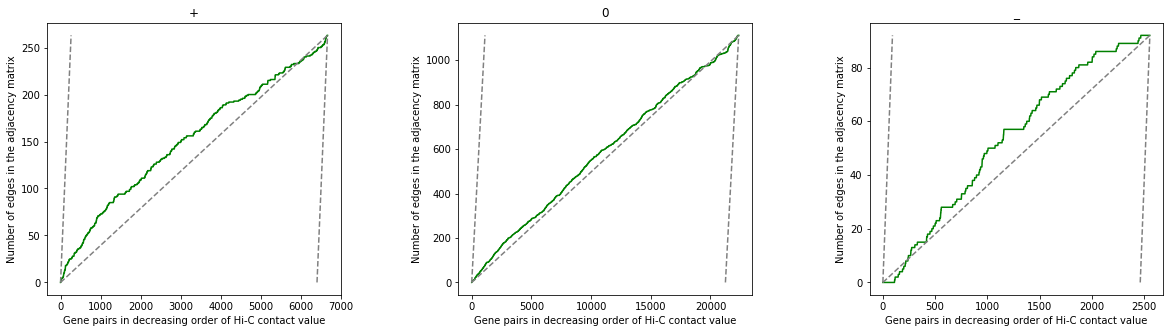

In [124]:
interaction_effects = np.unique(df_interactions['Effect'])

# Initialize empty figure
grid_size = [1,3]
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
effect_count = 0

for effect in interaction_effects:
    effect_count += 1
    
    # Only keep rows corresponding to effect
    df_interactions1 = df_interactions[df_interactions['Effect']==effect]
    # Drop duplicate rows based on source and target protein
    df_interactions1 = df_interactions1.drop_duplicates(subset=['Source','Target'], keep='first')
    

    # Create networkX adhesome network without node attributes
    adhesome_network = nx.from_pandas_edgelist(df_interactions1, 'Source', 'Target', 
                                            ['Effect', 'Type', 'PMID', 'data_source'])

    # Transform the adhesome network adjacency matrix to (index, column, value format)
    adhesome_network_df = nx.to_pandas_adjacency(adhesome_network, dtype=int)
    new_index = pd.MultiIndex.from_tuples(itertools.product(adhesome_network_df.index.tolist(),
                                                            adhesome_network_df.index.tolist()),
                                          names=["column","index"])
    adhesome_network_df1 = adhesome_network_df.stack().reindex(new_index).reset_index(name='edge')

    # Join gene_contacts_full_df1 and adhesome_network_df1
    combined_df = pd.merge(gene_contacts_full_df1, adhesome_network_df1, 
                           how='inner', on=['column','index'])
    combined_df = combined_df.sort_values(by='hic_contact', ascending=False)
    
    # Plot ROC curve
    ax = fig.add_subplot(grid_size[0], grid_size[1], effect_count)
    plt.plot(np.arange(len(combined_df)),np.cumsum(combined_df['edge']), color='green')
    plt.plot([0,len(combined_df)],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
    plt.plot([0,np.sum(combined_df['edge'])],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
    plt.plot([len(combined_df)-np.sum(combined_df['edge']),len(combined_df)],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
    ax.set_xlabel('Gene pairs in decreasing order of Hi-C contact value')
    ax.set_ylabel('Number of edges in the adjacency matrix')
    ax.set_title(effect)

plt.show()


# ROC based on interaction type

In [125]:
# Distribution of interaction types
df_interactions.Type.value_counts()

binding               5095
activation             324
inhibition             136
phosphorylation        114
dephosphorylation       33
direct_interaction      27
gef                     10
colocalization           7
unknown                  6
compound                 2
enzymatic                2
Name: Type, dtype: int64

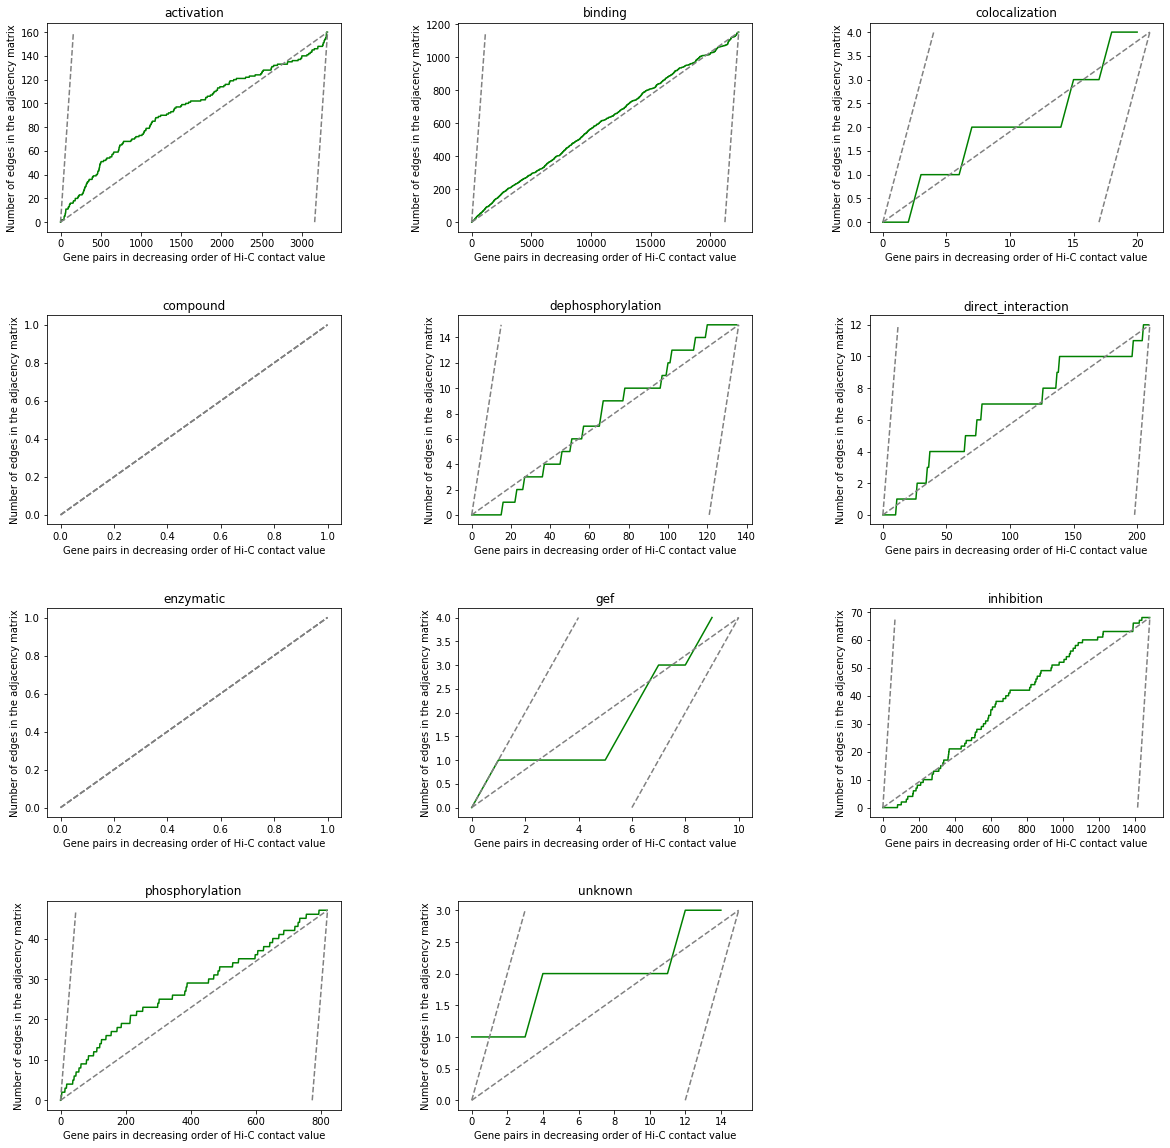

In [126]:
interaction_types = np.unique(df_interactions['Type'])

# Initialize empty figure
grid_size = [4,3]
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
type_count = 0

for int_type in interaction_types:
    type_count += 1
    
    # Only keep rows corresponding to effect
    df_interactions1 = df_interactions[df_interactions['Type']==int_type]
    # Drop duplicate rows based on source and target protein
    df_interactions1 = df_interactions1.drop_duplicates(subset=['Source','Target'], keep='first')
    

    # Create networkX adhesome network without node attributes
    adhesome_network = nx.from_pandas_edgelist(df_interactions1, 'Source', 'Target', 
                                            ['Effect', 'Type', 'PMID', 'data_source'])

    # Transform the adhesome network adjacency matrix to (index, column, value format)
    adhesome_network_df = nx.to_pandas_adjacency(adhesome_network, dtype=int)
    new_index = pd.MultiIndex.from_tuples(itertools.product(adhesome_network_df.index.tolist(),
                                                            adhesome_network_df.index.tolist()),
                                          names=["column","index"])
    adhesome_network_df1 = adhesome_network_df.stack().reindex(new_index).reset_index(name='edge')

    # Join gene_contacts_full_df1 and adhesome_network_df1
    combined_df = pd.merge(gene_contacts_full_df1, adhesome_network_df1, 
                           how='inner', on=['column','index'])
    combined_df = combined_df.sort_values(by='hic_contact', ascending=False)
    
    # Plot ROC curve
    ax = fig.add_subplot(grid_size[0], grid_size[1], type_count)
    plt.plot(np.arange(len(combined_df)),np.cumsum(combined_df['edge']), color='green')
    plt.plot([0,len(combined_df)],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
    plt.plot([0,np.sum(combined_df['edge'])],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
    plt.plot([len(combined_df)-np.sum(combined_df['edge']),len(combined_df)],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
    ax.set_xlabel('Gene pairs in decreasing order of Hi-C contact value')
    ax.set_ylabel('Number of edges in the adjacency matrix')
    ax.set_title(int_type)

plt.show()
